In [ ]:
# Instalasi
!pip install transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.0
    Uninstalling fsspec-2025.5.0:
      Successfully uninstalled fsspec-2025.5.0


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import upload_file

In [ ]:
from huggingface_hub import login

# Login menggunakan token
login()


In [ ]:
from huggingface_hub import HfApi, Repository
import os

repo_name = "indo_gru_bot"
username = "yazidsupriadi"  # Ganti dengan username kamu
full_repo_name = f"{username}/{repo_name}"

# Langkah: Clone repo yang sudah ada dari Hugging Face
local_dir = f"./{repo_name}"

# Kalau folder lokalnya belum ada, baru clone
if not os.path.exists(local_dir):
    repo = Repository(local_dir=local_dir, clone_from=full_repo_name)
else:
    repo = Repository(local_dir=local_dir)
    print(f"📁 Folder '{local_dir}' sudah ada, menggunakan repository lokal yang sudah tersedia.")

print("✅ Repository sudah siap digunakan.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  

Download file model.pt:   0%|          | 6.86k/477M [00:00<?, ?B/s]

Download file gru_bot_model.pth:   0%|          | 32.0k/23.3M [00:00<?, ?B/s]

Clean file gru_bot_model.pth:   0%|          | 1.00k/23.3M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.5 MB/s eta 0:00:00


In [ ]:
# Membaca dataset
df = pd.read_excel('/content/dataset.xlsx')

In [ ]:
def clean_text(text):
    text = re.sub(r"http\S+", "", str(text))
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    return text.strip()

df['clean_text'] = df['full_text'].apply(clean_text)

# Konversi kolom 'created_at' ke datetime
df["created_at"] = pd.to_datetime(df["created_at"], utc=True)
df["created_at"] = df["created_at"].dt.tz_convert(None)

# Menghitung tanggal pertama dan terakhir per pengguna
df["min_date"] = df.groupby("user_id_str")["created_at"].transform("min")
df["max_date"] = df.groupby("user_id_str")["created_at"].transform("max")

# Menghitung jumlah hari aktif
df["days_active"] = (df["max_date"] - df["min_date"]).dt.days + 1
df["days_active"] = df["days_active"].replace(0, 1)  # Hindari pembagian nol

# Menghitung jumlah tweet per pengguna
df["tweet_count"] = df.groupby("user_id_str")["user_id_str"].transform("count")

# Menghitung rata-rata tweet per hari
df["tweet_per_day"] = df["tweet_count"] / df["days_active"]

# Menghapus kolom sementara
df.drop(["min_date", "max_date", "days_active", "tweet_count"], axis=1, inplace=True)

# Label dummy: jika ada kata 'bot' di username → label 1
df['label'] = df['label'].apply(lambda x: 1 if 'bot' in str(x).lower() else 0)

<ipython-input-5-4dab96586f18>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["created_at"] = pd.to_datetime(df["created_at"], utc=True)


In [ ]:
df.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,clean_text,tweet_per_day
0,1919363195979940096,2025-05-06 22:56:03,1,@Baktiar1772371 Beda jenis Bang. Kalo kucing h...,1919888921078449920,NaN,Baktiar1772371,in,NaN,0,0,0,https://x.com/turtle_arc/status/19198889210784...,1630888763852460032,turtle_arc,1,Beda jenis Bang. Kalo kucing hutan gedenya gak...,8.350877
1,1919775484776440064,2025-05-06 15:54:50,2,@GuarEmperor Siap direkrut masuk sirkel elite ...,1919782921155510016,NaN,GuarEmperor,in,NaN,0,0,0,https://x.com/turtle_arc/status/19197829211555...,1630888763852460032,turtle_arc,1,Siap direkrut masuk sirkel elite mas GE,8.350877
2,1919747559662490112,2025-05-06 15:20:32,0,@ooovgbnd Alhamdulillah masih dapet,1919774287340379904,NaN,ooovgbnd,in,NaN,0,0,0,https://x.com/turtle_arc/status/19197742873403...,1630888763852460032,turtle_arc,1,Alhamdulillah masih dapet,8.350877
3,1919735516687209984,2025-05-06 12:50:23,0,@satyaXBT pasti adalah.. carinya di resto khus...,1919736501673289984,NaN,satyaXBT,in,NaN,0,0,0,https://x.com/turtle_arc/status/19197365016732...,1630888763852460032,turtle_arc,1,pasti adalah.. carinya di resto khusus indo bi...,8.350877
4,1919735516687209984,2025-05-06 12:47:43,3,@satyaXBT gasss pindah negara dong ketuaa.. wk...,1919735828202589952,NaN,satyaXBT,in,NaN,0,1,0,https://x.com/turtle_arc/status/19197358282025...,1630888763852460032,turtle_arc,1,gasss pindah negara dong ketuaa.. wkwkwk,8.350877


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

# Tokenizer IndoBERT
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
MAX_LEN = 128

# Fitur numerik tambahan
numeric_features = ['favorite_count', 'retweet_count', 'reply_count', 'quote_count', 'tweet_per_day']

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, numeric_data):
        self.texts = texts
        self.labels = labels
        self.numeric_data = numeric_data

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'numeric_feats': torch.tensor(self.numeric_data[idx], dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Menyiapkan data untuk DataLoader
train_numeric = train_df[numeric_features].values
val_numeric = val_df[numeric_features].values

train_dataset = TweetDataset(train_df["clean_text"].tolist(), train_df["label"].tolist(), train_numeric)
val_dataset = TweetDataset(val_df["clean_text"].tolist(), val_df["label"].tolist(), val_numeric)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn
from transformers import AutoModel

class IndoBERT_GRU(nn.Module):
    def __init__(self, numeric_input_dim):
        super(IndoBERT_GRU, self).__init__()
        self.bert = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")
        self.gru = nn.GRU(self.bert.config.hidden_size, 128, batch_first=True, bidirectional=True)

        self.numeric_fc = nn.Linear(numeric_input_dim, 32)

        self.fc1 = nn.Linear(128 * 2 + 32, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, numeric_feats):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        gru_output, _ = self.gru(bert_output)
        gru_output = gru_output[:, -1, :]

        numeric_out = torch.relu(self.numeric_fc(numeric_feats))

        combined = torch.cat((gru_output, numeric_out), dim=1)

        x = torch.relu(self.fc1(combined))
        logits = self.fc2(x)
        return self.sigmoid(logits)


In [ ]:
from huggingface_hub import login, HfApi, Repository
import os

# Login menggunakan token
login()


In [ ]:
from huggingface_hub import notebook_login
from huggingface_hub import notebook_login, Repository
from huggingface_hub import create_repo, upload_file
notebook_login()


In [ ]:
repo_id = "yazidsupriadi/indo_gru_bot"
local_dir = "indo_gru_bot"
os.makedirs(local_dir, exist_ok=True)
create_repo(repo_id, exist_ok=True)

RepoUrl('https://huggingface.co/yazidsupriadi/indo_gru_bot', endpoint='https://huggingface.co', repo_type='model', repo_id='yazidsupriadi/indo_gru_bot')

In [ ]:
from huggingface_hub import HfApi

log_file = os.path.join(local_dir, "training_log.md")
readme_file = os.path.join(local_dir, "README.md")

api = HfApi()

with open(log_file, "w") as f:
    f.write("# Training Log: IndoBERT + GRU for Bot Detection\n\n")


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import torch.nn as nn
import torch

# Device & Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IndoBERT_GRU(numeric_input_dim=len(numeric_features)).to(device)

# Loss & Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Untuk log training
train_losses = []
val_accuracies = []
val_roc_aucs = []
val_precisions = []
val_recalls = []
val_f1s = []

for epoch in range(10):  # Ganti sesuai kebutuhan
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        numeric_feats = batch["numeric_feats"].to(device)
        labels = batch["labels"].to(device).float()

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, numeric_feats).squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            numeric_feats = batch["numeric_feats"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask, numeric_feats).squeeze(-1)
            preds.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Thresholding predictions
    pred_labels = [1 if p > 0.5 else 0 for p in preds]

    val_acc = accuracy_score(true_labels, pred_labels)
    val_auc = roc_auc_score(true_labels, preds)
    val_precision = precision_score(true_labels, pred_labels, zero_division=0)
    val_recall = recall_score(true_labels, pred_labels, zero_division=0)
    val_f1 = f1_score(true_labels, pred_labels, zero_division=0)

    val_accuracies.append(val_acc)
    val_roc_aucs.append(val_auc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(
        f"Epoch {epoch+1} - Loss: {avg_train_loss:.4f} - "
        f"Val Accuracy: {val_acc:.4f} - Val ROC AUC: {val_auc:.4f} - "
        f"Precision: {val_precision:.4f} - Recall: {val_recall:.4f} - F1: {val_f1:.4f}"
    )

    # Simpan model setiap epoch
    model_path = f"model_epoch_{epoch+1}.pt"
    torch.save(model.state_dict(), model_path)

    # Upload ke Hugging Face
    api.upload_file(
        path_or_fileobj=model_path,
        path_in_repo=f"model_epoch_{epoch+1}.pt",
        repo_id=repo_id,
        repo_type="model"
    )


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 1000/1000 [06:22<00:00,  2.61it/s]


Epoch 1 - Loss: 1.7832 - Val Accuracy: 0.8908 - Val ROC AUC: 0.9592 - Precision: 0.9005 - Recall: 0.8794 - F1: 0.8898


model_epoch_1.pt:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch 2: 100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


Epoch 2 - Loss: 0.2684 - Val Accuracy: 0.9002 - Val ROC AUC: 0.9667 - Precision: 0.9178 - Recall: 0.8799 - F1: 0.8984


model_epoch_2.pt:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch 3: 100%|██████████| 1000/1000 [06:12<00:00,  2.69it/s]


Epoch 3 - Loss: 0.2454 - Val Accuracy: 0.9048 - Val ROC AUC: 0.9709 - Precision: 0.9216 - Recall: 0.8853 - F1: 0.9031


model_epoch_3.pt:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch 4: 100%|██████████| 1000/1000 [06:14<00:00,  2.67it/s]


Epoch 4 - Loss: 0.2293 - Val Accuracy: 0.9113 - Val ROC AUC: 0.9746 - Precision: 0.9422 - Recall: 0.8769 - F1: 0.9083


model_epoch_4.pt:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch 5: 100%|██████████| 1000/1000 [06:08<00:00,  2.72it/s]


Epoch 5 - Loss: 0.2187 - Val Accuracy: 0.9163 - Val ROC AUC: 0.9767 - Precision: 0.9327 - Recall: 0.8978 - F1: 0.9149


model_epoch_5.pt:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch 6: 100%|██████████| 1000/1000 [06:09<00:00,  2.71it/s]


Epoch 6 - Loss: 0.2114 - Val Accuracy: 0.9183 - Val ROC AUC: 0.9784 - Precision: 0.9384 - Recall: 0.8958 - F1: 0.9166


model_epoch_6.pt:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch 7: 100%|██████████| 1000/1000 [06:15<00:00,  2.67it/s]


Epoch 7 - Loss: 0.2022 - Val Accuracy: 0.9205 - Val ROC AUC: 0.9797 - Precision: 0.9475 - Recall: 0.8908 - F1: 0.9183


model_epoch_7.pt:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch 8: 100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]


Epoch 8 - Loss: 0.2000 - Val Accuracy: 0.9227 - Val ROC AUC: 0.9803 - Precision: 0.9408 - Recall: 0.9028 - F1: 0.9214


model_epoch_8.pt:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch 9: 100%|██████████| 1000/1000 [06:20<00:00,  2.63it/s]


Epoch 9 - Loss: 0.1881 - Val Accuracy: 0.9255 - Val ROC AUC: 0.9816 - Precision: 0.9309 - Recall: 0.9197 - F1: 0.9253


model_epoch_9.pt:   0%|          | 0.00/501M [00:00<?, ?B/s]

Epoch 10: 100%|██████████| 1000/1000 [06:14<00:00,  2.67it/s]


Epoch 10 - Loss: 0.1887 - Val Accuracy: 0.9265 - Val ROC AUC: 0.9821 - Precision: 0.9293 - Recall: 0.9237 - F1: 0.9265


model_epoch_10.pt:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report for final epoch
report = classification_report(true_labels, pred_labels, zero_division=0)


# Generate model card (README.md)
readme_file = "README.md"

with open(readme_file, "w") as f:
    f.write("# IndoBERT-GRU for Bot Detection on Platform X\n\n")
    f.write("This model uses **IndoBERT + GRU** to classify Twitter/X accounts as bots or humans based on their textual content and numeric features.\n\n")

    f.write("## Model Architecture\n")
    f.write("- Base Model: `indobenchmark/indobert-base-p1`\n")
    f.write("- RNN Type: Bidirectional GRU\n")
    f.write("- Classifier: 2-layer feedforward with ReLU + Sigmoid\n\n")

    f.write("## Dataset\n")
    f.write("The dataset includes Indonesian tweets with labels (`0` for human, `1` for bot), along with additional numeric features such as `favorite_count`, `retweet_count`, `reply_count`, and `quote_count`.\n\n")

    f.write("## Training Details\n")
    f.write(f"- Loss Function: Binary Cross Entropy (BCELoss)\n")
    f.write(f"- Optimizer: Adam (lr = 2e-5)\n")
    f.write(f"- Epochs: {len(train_losses)}\n")
    f.write(f"- Max Token Length: 128\n")
    f.write(f"- Batch Size: 16\n\n")

    f.write("### Training Log\n")
    f.write("| Epoch | Train Loss | Val Accuracy | Precision | Recall | F1-score |\n")
    f.write("|-------|------------|--------------|-----------|--------|----------|\n")
    for i, (loss, acc, prec, rec, f1) in enumerate(zip(train_losses, val_accuracies, val_precisions, val_recalls, val_f1s)):
        f.write(f"| {i+1} | {loss:.4f} | {acc:.4f} | {prec:.4f} | {rec:.4f} | {f1:.4f} |\n")
    f.write("\n")

    f.write("## Evaluation Results\n")
    f.write(f"**Final Validation Accuracy**: {val_accuracies[-1]:.4f}\n\n")
    f.write("### Confusion Matrix\n")
    f.write("![Confusion Matrix](./confusion_matrix.png)\n\n")
    f.write("### Training Phase\n")
    f.write("![Training Phase](./training_phase.png)\n\n")
    f.write("### Classification Report\n")
    f.write("```\n")
    f.write(report)
    f.write("\n```\n")

    f.write(f"**Final Precision**: {val_precisions[-1]:.4f}\n")
    f.write(f"**Final Recall**: {val_recalls[-1]:.4f}\n")
    f.write(f"**Final F1-score**: {val_f1s[-1]:.4f}\n\n")



In [ ]:
from huggingface_hub import upload_file

repo_id = "yazidsupriadi/indo_gru_bot"  # Ganti dengan repo kamu

# Upload file ke Hugging Face
upload_file(path_or_fileobj=readme_file, path_in_repo="README.md", repo_id=repo_id, repo_type="model")
upload_file(path_or_fileobj="./confusion_matrix.png", path_in_repo="confusion_matrix.png", repo_id=repo_id, repo_type="model")
upload_file(path_or_fileobj="./training_phase.png", path_in_repo="training_phase.png", repo_id=repo_id, repo_type="model")
upload_file(path_or_fileobj="./roc.png", path_in_repo="roc.png", repo_id=repo_id, repo_type="model")
print("✅ README.md dan confusion matrix berhasil diupload ke model card Hugging Face.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


✅ README.md dan confusion matrix berhasil diupload ke model card Hugging Face.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Konversi ke label diskret
pred_labels = [1 if p > 0.5 else 0 for p in preds]

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "Bot"], yticklabels=["Human", "Bot"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("./confusion_matrix.png")
plt.close()  # Agar plot tidak tetap terbuka jika dalam loop

# Classification Report
report = classification_report(true_labels, pred_labels, target_names=["Human", "Bot"], zero_division=0)
print("\nClassification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

       Human       0.92      0.93      0.93      1994
         Bot       0.93      0.92      0.93      2006

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



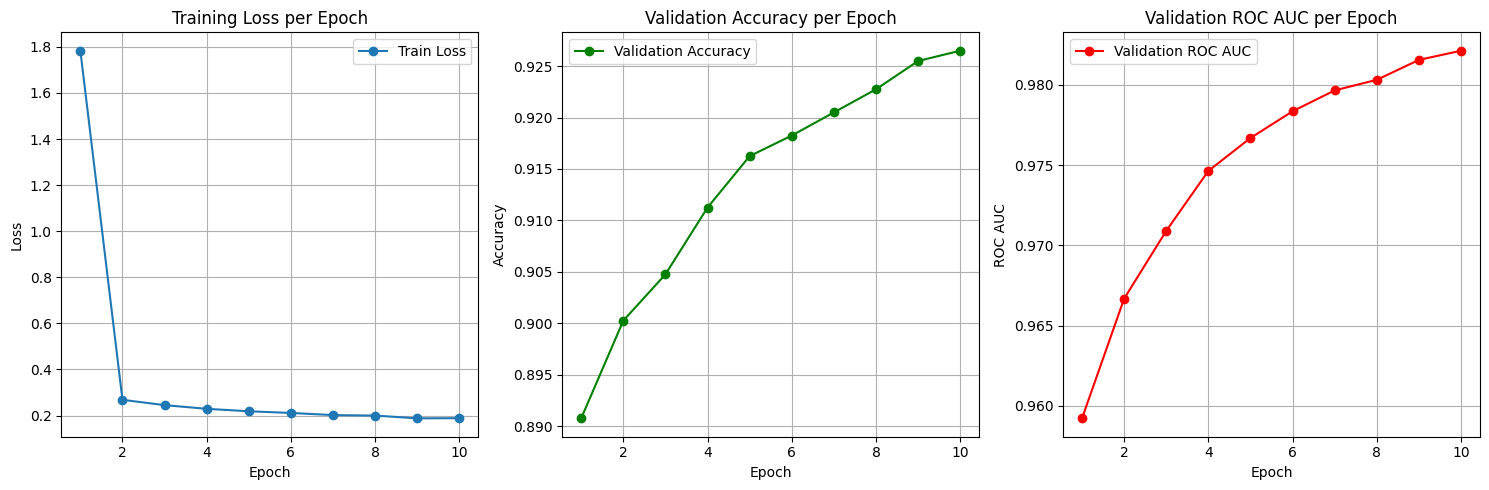

In [ ]:
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, val_accuracies, marker='o', color='green', label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot ROC AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, val_roc_aucs, marker='o', color='red', label='Validation ROC AUC')
plt.title('Validation ROC AUC per Epoch')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.legend()

plt.tight_layout()

plt.savefig("./training_phase.png")  # Simpan gambar dulu
plt.show()  # Baru tampilkan

plt.close()


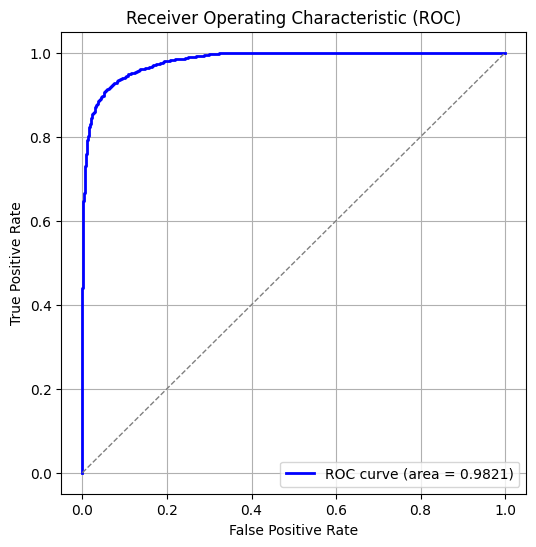

In [ ]:
# Kode untuk prediksi ulang (ROC membutuhkan probabilitas, bukan prediksi biner)
model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        numeric_feats = batch["numeric_feats"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask, numeric_feats).squeeze(-1)
        preds.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig("./roc.png")  # Simpan gambar dulu
plt.show()  # Baru tampilkan

plt.close()


In [ ]:
repo_name = "indo_gru_bot"
username = "yazidsupriadi"  # Ganti dengan username kamu
full_repo_name = f"{username}/{repo_name}"

# Direktori lokal untuk repository
local_dir = f"./{repo_name}"

# Clone atau gunakan repository lokal
if not os.path.exists(local_dir):
    repo = Repository(local_dir=local_dir, clone_from=full_repo_name)
else:
    repo = Repository(local_dir=local_dir)
    print(f"📁 Folder '{local_dir}' sudah ada, menggunakan repository lokal yang sudah tersedia.")

# Simpan model
model_save_path = os.path.join(local_dir, "model.pt")
torch.save(model.state_dict(), model_save_path)

# Commit dan push ke Hugging Face Hub
repo.push_to_hub(commit_message="Menambahkan model IndoBERT_GRU dengan fitur numerik")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)


ValueError: If not specifying `clone_from`, you need to pass Repository a valid git clone.

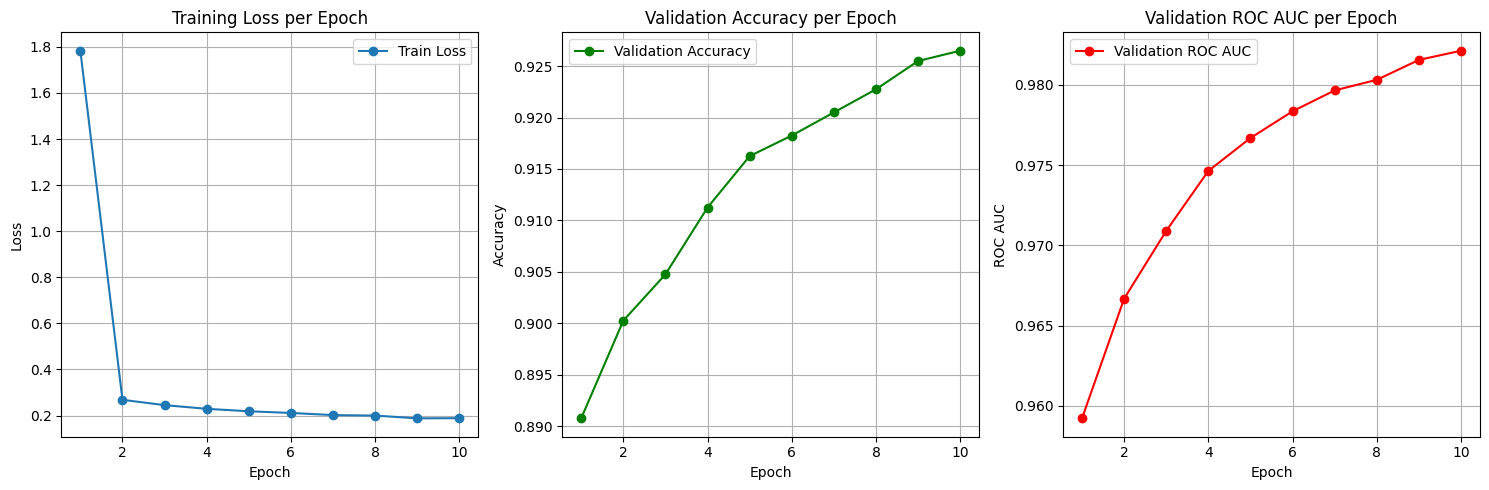

In [ ]:
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, val_accuracies, marker='o', color='green', label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot ROC AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, val_roc_aucs, marker='o', color='red', label='Validation ROC AUC')
plt.title('Validation ROC AUC per Epoch')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
plt.savefig("/training_metrics.png")  # Ganti path sesuai kebutuhan

plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
plt.savefig("./training_metrics.png")  # Ganti path sesuai kebutuhan

plt.show()

<Figure size 640x480 with 0 Axes>


Classification Report:
              precision    recall  f1-score   support

       Human       0.84      0.86      0.85      1994
         Bot       0.86      0.84      0.85      2006

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



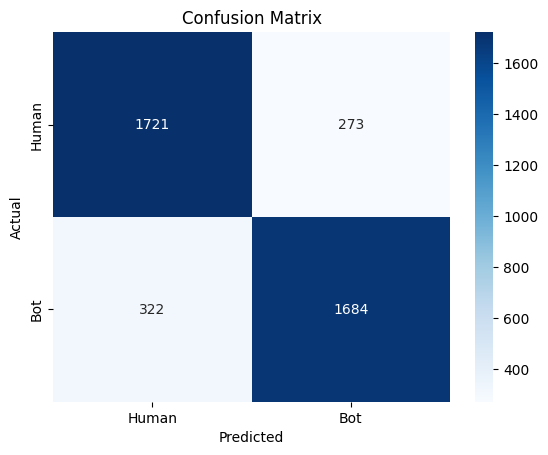

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "Bot"], yticklabels=["Human", "Bot"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("./confusion_matrix.png")

# Classification Report
report = classification_report(true_labels, preds, target_names=["Human", "Bot"])
print("\nClassification Report:")
print(report)

In [ ]:
from huggingface_hub import upload_file

repo_id = "yazidsupriadi/indo_gru_bot"  # Ganti dengan repo kamu

# Upload file ke Hugging Face
upload_file(path_or_fileobj=readme_file, path_in_repo="README.md", repo_id=repo_id, repo_type="model")
upload_file(path_or_fileobj="confusion_matrix.png", path_in_repo="confusion_matrix.png", repo_id=repo_id, repo_type="model")

print("✅ README.md dan confusion matrix berhasil diupload ke model card Hugging Face.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9627: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
No files have been modified since last commit. Skipping to prevent empty commit.


✅ README.md dan confusion matrix berhasil diupload ke model card Hugging Face.
